In [1]:
using Printf, Dates, Statistics, DelimitedFiles, StatsBase

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :svg)

# Load Data

In [3]:
x   = readdlm("Data/25_Portfolios_5x5_Daily.CSV",',',skipstart=1)        #daily return data
ym  = round.(Int,x[:,1])          #yearmonthday, like 20071231

dN = Date.(string.(ym),"yyyymmdd")      #covert to Julia date, eg. 2001-12-31


vv = Date(1980,1,1) .<= dN .<= Date(2020,12,31)   #pick out the correct sample
ym = ym[vv]
R = x[vv,2:end]                   #returns

(T,n) = size(R)                   #number of data points, number of assets

(10340, 25)

# Task 1: Two Simple Strategies

`R_1`: go long each of asset 1-24 (each with the weight 1/24) and short asset 25

`R_2`: go long asset 1 and short asset 25

The returns of these portfolios are easy to calculate without having to explicitly construct the portfolio weights, but it still a good preparation for later to do the explicit calculations as follows:

1. Construct the vector of portfolio weights `w`
2. The portfolio return in `t` is `w'*R[t,:]`.

Also, do not be afraid of loops: they are quick.

Show means and standard deviations of the two strategies. Annualize the mean by `*252`  and the standard deviation by `*sqrt(252)`.

Plot histograms with bins that are 0.25 wide. (Don't annualize anything in the histograms.)

In [4]:
w1 = [ones(24)/24;-1]        #static
w2 = [1;zeros(23);-1]

(R_1,R_2) = (fill(NaN,T),fill(NaN,T))
for t = 1:T                 
    R_1[t] = w1'*R[t,:]
    R_2[t] = w2'*R[t,:]
end

In [5]:
R_all = [R_1 R_2]

μ  = mean(R_all,dims=1)*252
σ  = std(R_all,dims=1)*sqrt(252)
SR = μ./σ

printmat([μ;σ;SR],colNames=["R_1","R_2"],rowNames=["mean","std","SR"])

           R_1       R_2
mean    -0.348    -8.665
std     13.860    18.996
SR      -0.025    -0.456



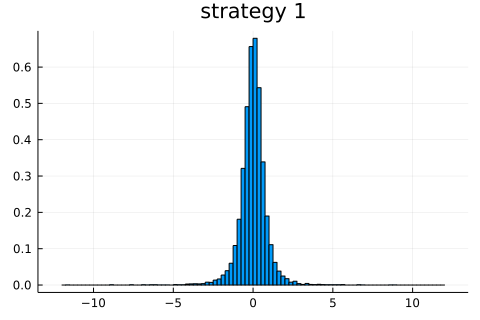

In [6]:
plt = histogram( R_1,bins = -12:0.25:12,normalize=true,legend=false,title="strategy 1" )
display(plt)

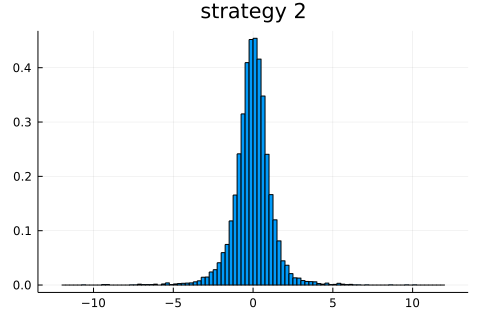

In [7]:
plt = histogram( R_2,bins = -12:0.25:12,normalize=true,legend=false,title="strategy 2" )
display(plt)

# Task 2: Another Trading Strategy

We now do simple volatility based trading strategy.

1. Find the 3 least volatile assets over `t-22:t-1` and give each a portfolio weight `w[t,i]=1/3`. 

2. Find the 3 most volatile assets over `t-22:t-1` and give each a portfolio weight `w[t,i]=-1/3`. 

3. The portfolio return in `t` is `w[t,:]'*R[t,:]`.

4. Compare the average and std (annualized) with the previous portfolios, over periods `23:T`

Hint: `v = sortperm(x)` gives indices such that `v[1:2]` are the indices of the lowest 2 elements in x. Try `sortperm([12,11,13])` to see.

In [8]:
v = sortperm([12,11,13])

printmat(v[1:2])

     2    
     1    



In [9]:
σ_moving = fill(NaN,T,n)
for t = 22:T
    σ_moving[t,:] = std(R[t-21:t,:],dims=1)
end    

In [10]:
m = 3                #number of long/short positions 

R_3 = fill(NaN,T)
for t = 23:T         #loop over periods, save portfolio returns
    #local s,w       #local/global is needed in script
    s                  = sortperm(σ_moving[t-1,:])
    w                  = zeros(n)
    w[s[1:m]]         .= 1/m
    w[s[end-m+1:end]] .= -1/m
    R_3[t]             = w'R[t,:]
end

In [11]:
R_all = [R_1[23:end] R_2[23:end] R_3[23:end]]

μ  = mean(R_all,dims=1)*252
σ  = std(R_all,dims=1)*sqrt(252)
SR = μ./σ

printmat([μ;σ;SR],colNames=["R_1","R_2","Vol sort"],rowNames=["avg return","std","SR"])

                 R_1       R_2  Vol sort
avg return    -0.281    -8.739     3.628
std           13.867    19.002    14.867
SR            -0.020    -0.460     0.244

